# Reptile: A Scalable Meta-Learning Algorithm
## Implemented with PyTorch

Link: https://openai.com/blog/reptile/

We’ve developed a simple meta-learning algorithm called Reptile which works by repeatedly sampling a task, performing stochastic gradient descent on it, and updating the initial parameters towards the final parameters learned on that task. 

Reptile is the application of the Shortest Descent algorithm to the meta-learning setting, and is mathematically similar to first-order MAML (which is a version of the well-known MAML algorithm) that only needs black-box access to an optimizer such as SGD or Adam, with similar computational efficiency and performance.

Paper: https://arxiv.org/abs/1803.02999

Code: https://github.com/openai/supervised-reptile

Meta-learning is the process of learning how to learn. A meta-learning algorithm takes in a distribution of tasks, where each task is a learning problem, and it produces a quick learner — a learner that can generalize from a small number of examples. One well-studied meta-learning problem is few-shot classification, where each task is a classification problem where the learner only sees 1–5 input-output examples from each class, and then it must classify new inputs.

## How Reptile Works## How Reptile Works

Like MAML, Reptile seeks an **initialization** for the parameters of a neural network, such that the network can be fine-tuned using a small amount of data from a new task. 

But while MAML unrolls and differentiates through the computation graph of the gradient descent algorithm, Reptile simply performs stochastic gradient descent (SGD) on each task in a standard way — it does not unroll a computation graph or calculate any second derivatives. This makes Reptile take less computation and memory than MAML. The pseudocode is as follows:

    Initialize Φ, the initial parameter vector
    **for** iteration 1,2,3,... **do**
      Randomly sample a task $T$
      Perform $k>1$ steps of SGD on task $T$, starting with parameters Φ, resulting in parameters $W$
      Update: Φ ← Φ + $\epsilon(W-Φ)$
    **end for**
    Return Φ

As an alternative to the last step, we can treat \Phi - WΦ−W as a gradient and plug it into a more sophisticated optimizer like [Adam](https://arxiv.org/abs/1412.6980).

It is at first surprising that this method works at all. If k=1, this algorithm would correspond to “joint training” — performing SGD on the mixture of all tasks. While joint training can learn a useful initialization in some cases, it learns very little when zero-shot learning is not possible (e.g. when the output labels are randomly permuted). Reptile requires k&gt;1k>1, where the update depends on the higher-order derivatives of the loss function; as we show in the paper, this behaves very differently from k=1 (joint training).

To analyze why Reptile works, we approximate the update using a Taylor series. We show that the Reptile update maximizes the inner product between gradients of different minibatches from the same task, corresponding to improved generalization. This finding may have implications outside of the meta-learning setting for explaining the generalization properties of SGD. Our analysis suggests that Reptile and MAML perform a very similar update, including the same two terms with different weights.

In our experiments, we show that Reptile and MAML yield similar performance on the Omniglot and Mini-ImageNet benchmarks for few-shot classification. Reptile also converges to the solution faster, since the update has lower variance.

Our analysis of Reptile suggests a plethora of different algorithms that we can obtain using different combinations of the SGD gradients. In the figure below, assume that we perform k steps of SGD on each task using different minibatches, yielding gradients g_1, g_2, ..., g_k. The figure below shows the learning curves on Omniglot obtained by using each sum as the meta-gradient. 

g_2 corresponds to first-order MAML, an algorithm proposed in the original MAML paper. Including more gradients yields faster learning, due to variance reduction. Note that simply using g_1 (which corresponds to k=1) yields no progress as predicted for this task since zero-shot performance cannot be improved.

![image](https://openai.com/content/images/2018/03/reptile-chart.png)

## Implementations

Here’s a minimal example of few-shot regression, predicting a random sine wave from $10 (x, y)$ pairs. This one uses PyTorch and fits in a gist:

In [1]:
import numpy as np
import torch
from torch import nn, autograd as ag
import matplotlib.pyplot as plt
from copy import deepcopy

In [2]:
seed = 0
plot = True
inner_stepsize = 0.02 # step size in inner SGD
inner_epochs = 1 # number of epochs of each inner SGD
outer_stepsize = 0.1 # step size of outer optimization, i.e., meta-optimization
niterations = 30000 # number of outer updates; each interation we sample one task and update on it

In [3]:
rng = np.random.RandomState(seed)
torch.manual_seed(seed)

In [5]:
# Define task distribution
x_all = np.linspace(-5, 5, 50)[:, None] # All of the x points
ntrain = 10 # size of training minibatches

x_all.shape

(50, 1)

In [6]:
def gen_task():
    """
    Generate classification problem.
    """
    phase = rng.uniform(low=0, high=2*np.pi)
    ampl = rng.uniform(0.1, 5)
    f_random_sine = lambda x: np.sin(x + phase) * ampl
    return f_random_sine

In [8]:
# Define model. Reptile paper uses ReLU, but Tanh gives slightly better results
model = nn.Sequential(
    nn.Linear(1, 64),
    nn.Tanh(),
    nn.Linear(64, 64),
    nn.Tanh(),
    nn.Linear(64, 1)
)

In [9]:
print(model)

Sequential(
  (0): Linear(in_features=1, out_features=64, bias=True)
  (1): Tanh()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): Tanh()
  (4): Linear(in_features=64, out_features=1, bias=True)
)


In [10]:
def totorch(x):
    return ag.Variable(torch.Tensor(x))

In [11]:
def train_on_batch(x, y):
    x = totorch(x)
    y = totorch(y)
    model.zero_grad()
    y_pred = model(x)
    loss = (y_pred - y).pow(2).mean()
    loss.backward()
    for param in model.parameters():
        param.data -= inner_stepsize * param.grad.data

In [12]:
def predict(x):
    x = totorch(x)
    return model(x).data.numpy()

In [13]:
# Choose a fixed task and minibatch for visualization
f_plot = gen_task()
xtrain_plot = x_all[rng.choice(len(x_all), size=ntrain)]

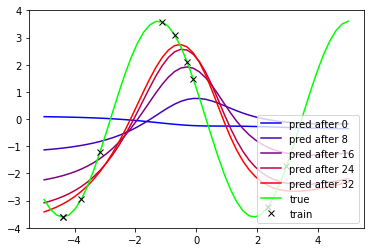

------------------------------
iteration               1
loss on plotted curve  5.523


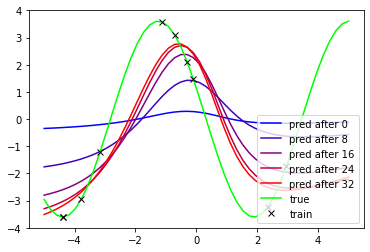

------------------------------
iteration               1000
loss on plotted curve  5.081


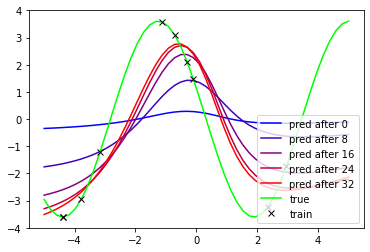

------------------------------
iteration               2000
loss on plotted curve  5.081


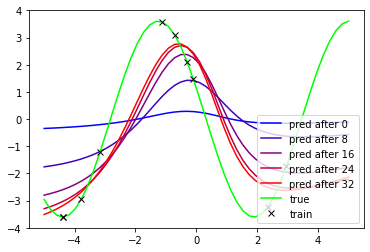

------------------------------
iteration               3000
loss on plotted curve  5.081


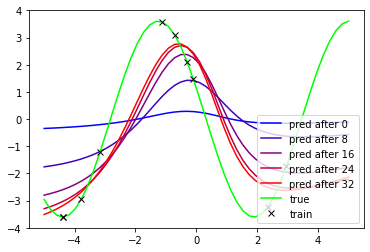

------------------------------
iteration               4000
loss on plotted curve  5.081


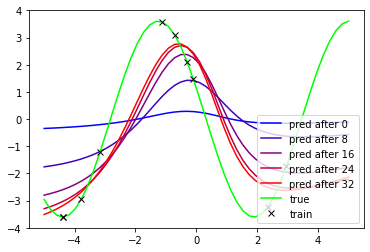

------------------------------
iteration               5000
loss on plotted curve  5.081


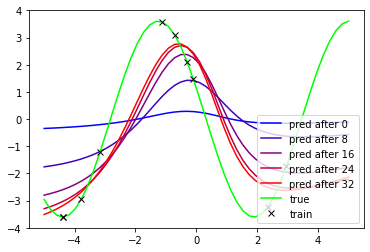

------------------------------
iteration               6000
loss on plotted curve  5.081


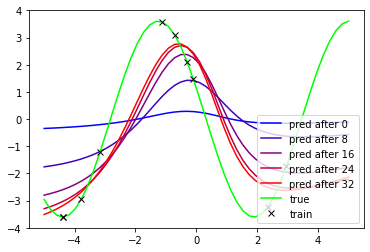

------------------------------
iteration               7000
loss on plotted curve  5.081


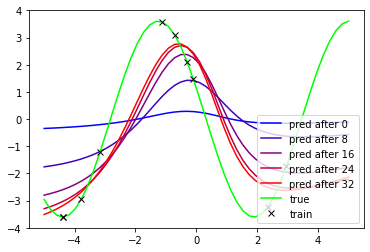

------------------------------
iteration               8000
loss on plotted curve  5.081


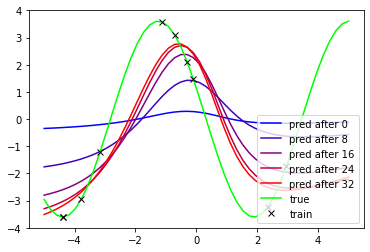

------------------------------
iteration               9000
loss on plotted curve  5.081


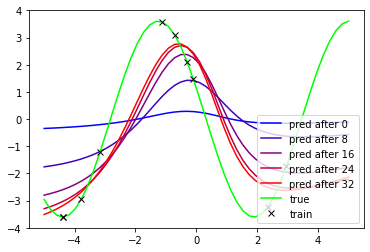

------------------------------
iteration               10000
loss on plotted curve  5.081


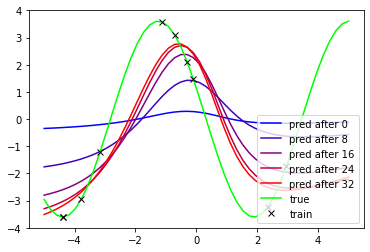

------------------------------
iteration               11000
loss on plotted curve  5.081


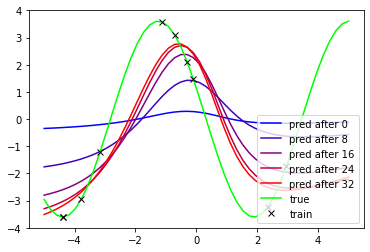

------------------------------
iteration               12000
loss on plotted curve  5.081


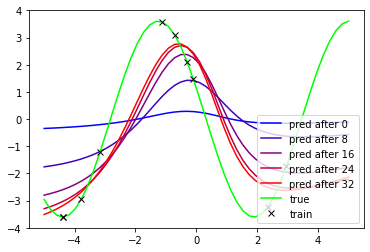

------------------------------
iteration               13000
loss on plotted curve  5.081


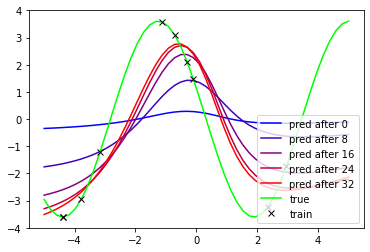

------------------------------
iteration               14000
loss on plotted curve  5.081


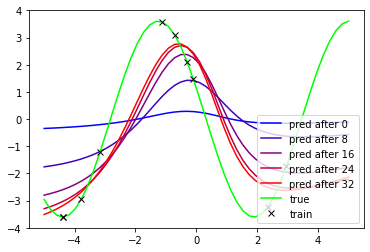

------------------------------
iteration               15000
loss on plotted curve  5.081


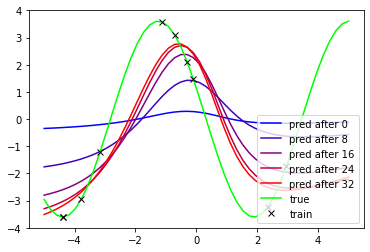

------------------------------
iteration               16000
loss on plotted curve  5.081


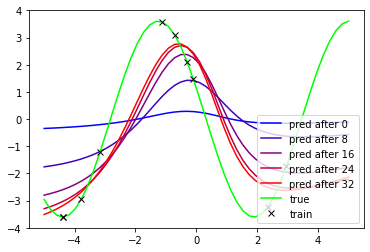

------------------------------
iteration               17000
loss on plotted curve  5.081


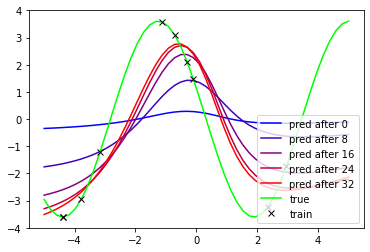

------------------------------
iteration               18000
loss on plotted curve  5.081


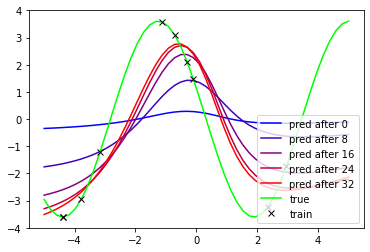

------------------------------
iteration               19000
loss on plotted curve  5.081


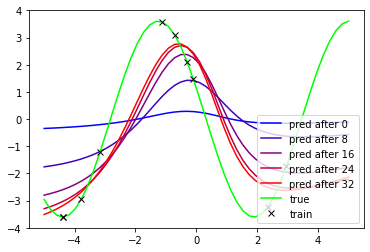

------------------------------
iteration               20000
loss on plotted curve  5.081


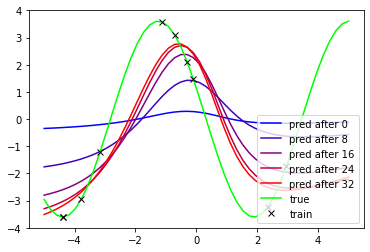

------------------------------
iteration               21000
loss on plotted curve  5.081


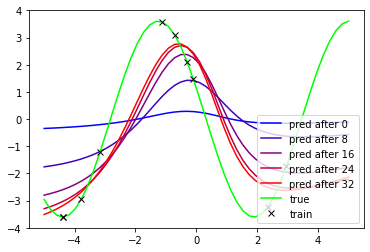

------------------------------
iteration               22000
loss on plotted curve  5.081


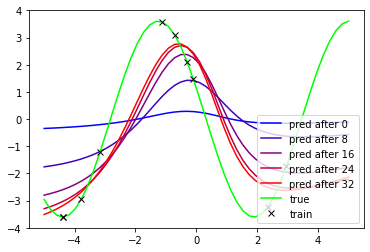

------------------------------
iteration               23000
loss on plotted curve  5.081


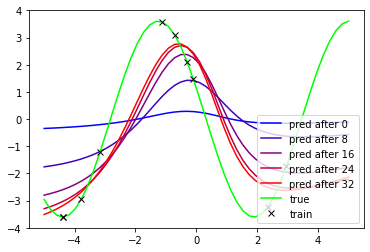

------------------------------
iteration               24000
loss on plotted curve  5.081


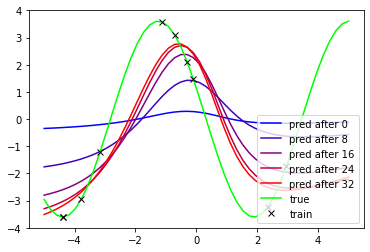

------------------------------
iteration               25000
loss on plotted curve  5.081


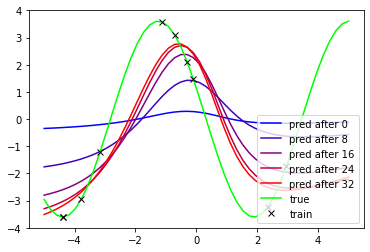

------------------------------
iteration               26000
loss on plotted curve  5.081


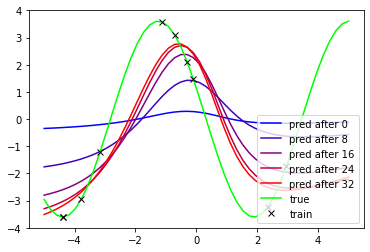

------------------------------
iteration               27000
loss on plotted curve  5.081


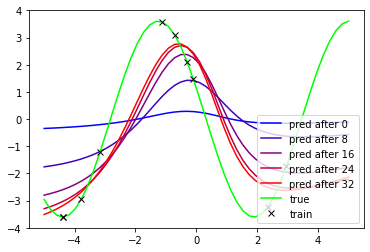

------------------------------
iteration               28000
loss on plotted curve  5.081


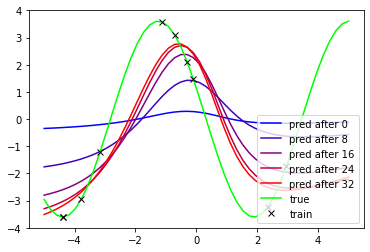

------------------------------
iteration               29000
loss on plotted curve  5.081


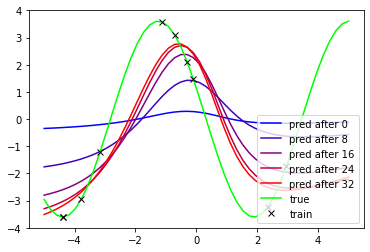

------------------------------
iteration               30000
loss on plotted curve  5.081


In [15]:
# Reptile training loop
for iteration in range(niterations):
    weights_before = deepcopy(model.state_dict())
    
    # Generate task
    f = gen_task()
    y_all = f(x_all)
    
    # Do SGD on this task
    inds = rng.permutation(len(x_all))
    for _ in range(inner_epochs):
        for start in range(0, len(x_all), ntrain):
            mbinds = inds[start : start+ntrain]
            train_on_batch(x_all[mbinds], y_all[mbinds])
            
    # Interpolate between current weights and trained weights from this task
    # I.e. (weights_before - weights_after) is the meta gradient
    weights_after = model.state_dict()
    outer_stepsize = outer_stepsize * (1 - iteration / niterations) # linear schedule
    model.load_state_dict({name: 
                          weights_before[name] + (weights_after[name] - weights_before[name]) * outer_stepsize
                          for name in weights_before})
    
    # Periodically plot the results on a particular task and minibatch
    if plot and iteration == 0 or (iteration+1) % 1000 == 0:
        plt.cla()
        f = f_plot
        weights_before = deepcopy(model.state_dict()) # save snapshot before evaluation
        plt.plot(x_all, predict(x_all), label="pred after 0", color=(0,0,1))
        for inner_iter in range(32):
            train_on_batch(xtrain_plot, f(xtrain_plot))
            if (inner_iter+1) % 8 == 0:
                frac = (inner_iter+1) / 32
                plt.plot(x_all, predict(x_all), label="pred after %i"%(inner_iter+1), color=(frac,0,1-frac))
        plt.plot(x_all, f(x_all), label="true", color=(0,1,0))
        
        lossval = np.square(predict(x_all) - f(x_all)).mean()
        plt.plot(xtrain_plot, f(xtrain_plot), "x", label="train", color="k")
        plt.ylim(-4, 4)
        plt.legend(loc="lower right")
        plt.pause(0.01)
        model.load_state_dict(weights_before) # restore from snapshot
        print(f"------------------------------")
        print(f"iteration               {iteration+1}")
        print(f"loss on plotted curve  {lossval:.3f}") 
        # would be better to average loss over a set of examples,
        # but this is optimized for brevity